In [1]:
import numpy as np
import binascii
from random import getrandbits

from qunetsim.components.host import Host
from qunetsim.components.network import Network
from qunetsim.objects import Qubit
from qunetsim.objects import Logger
Logger.DISABLED = True

Welcome to BB84 demo


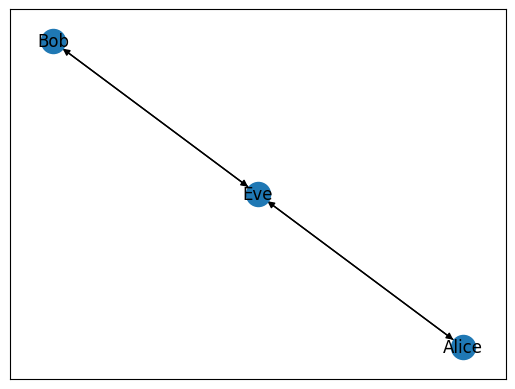

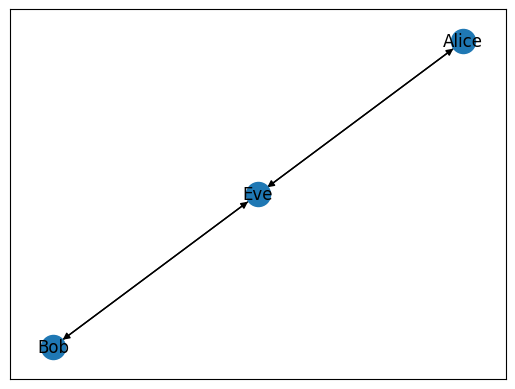

alice_bitstring:  0001100100
alice_bases:  0011110001
Bob_bases:  0001100100
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x1328278b0>
Intercepted message string:  0
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x1321cd760>
Intercepted message string:  0
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x1321cdc70>
Intercepted message string:  0
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x132628bb0>
Intercepted message string:  1
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x1321c1670>
Intercepted message string:  1
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x1321e87f0>
Intercepted message string:  0
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x127dfca00>
Intercepted message string:  0
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x127dfcca0>
Intercepted message string:  1
Intercepted qubits:  <qunetsim.objects.qubit.Qubit object at 0x127df93a0>
Intercept

IndexError: string index out of range

In [5]:
class BB84:
    def __init__(self):
        print("Welcome to BB84 demo")

    def select_encoding(self, length):
        alice_bitstring = ""
        alice_bases = ""
        for i in range(length):
            alice_bitstring += (str(getrandbits(1)))
            alice_bases += (str(getrandbits(1)))
            # 0 means (0,1) basis and 1 means(+,-)basis
        return alice_bitstring, alice_bases

    def select_measurement(self, length):   # Bob bases
        bases = ""
        for i in range(length):
            bases += (str(getrandbits(1)))
        return bases

    def encode(self, host_sender, bitstring, bases):
        encoded_qubits = []
        for i in range(len(bitstring)):
            q = Qubit(host_sender)
            if bases[i] == "0":
                if bitstring[i] == "0":
                    pass  # initialized in 0
                elif bitstring[i] == "1":
                    q.X()
            elif bases[i] == "1":
                if bitstring[i] == "0":
                    q.H()
                elif bitstring[i] == "1":
                    q.X()
                    q.H()
            encoded_qubits.append(q)
        # Stop the network at the end of the example
        # network.stop(stop_hosts=True)
        return encoded_qubits

    def send(self, sender_host, receiver_host, message):
        ids = []
        for q in message:
            # print(q)
            q_id, _ = sender_host.send_qubit(receiver_host.host_id,
                                             q, await_ack=True)
            ids.append(q_id)
        return ids

    def receive(self, receiver_host, sender_host, len_msg): #, ids):
        message = []
        #for q_id in ids:
        for i in range(len_msg):
            q_rec = receiver_host.get_data_qubit(sender_host.host_id)
            message.append(q_rec)
        return message

    def measurement(self, bases, encoded_qubits):
        bitstring = ''
        bits = []

        for i in range(len(encoded_qubits)):
            qc = encoded_qubits[i]
            if bases[i] == "0":
                measured_bit = qc.measure()  # Z basis
            elif bases[i] == "1":
                qc.H()
                measured_bit = qc.measure()  # X basis
            bits.append(measured_bit)
            bitstring += str(measured_bit)
        return bits, bitstring

    # Sending bases through classical channels
    def send_classically(self, host_sender, message, key_size, host_receiver):
        seq_no = 0
        for class_bit in message:
            host_sender.send_classical(host_receiver.host_id, class_bit,
                                       await_ack=True)
            seq_no += 1
        return seq_no

    def receive_classically(self, host_receiver, host_sender, seq_no):
        received_counter = 0
        received_msg = []
        received_msg_str = ''
        msg_buff = []
        while received_counter < seq_no:
            message = host_receiver.get_classical(host_sender.host_id,
                                                  received_counter)
            received_msg.append(message.content)
            received_msg_str += str(message.content)
            received_counter += 1
        return received_msg, received_msg_str

    def compare_bases(self, target_bases, bases):
        indices = []

        for i in range(len(target_bases)):
            if target_bases[i] == bases[i]:
                indices.append(i)

        return indices

    def construct_key_from_indices(self, bitstring, indices):
        key = ''
        for idx in indices:
            key = key + bitstring[idx]
        return key

    def encrypt_message(self, unencrypted_string, key):
        bits = bin(int(binascii.hexlify(unencrypted_string.encode('utf8',
                                        'surrogatepass')), 16))[2:]
        bitstring = bits.zfill(8 * ((len(bits) + 7) // 8))
        #print(len(bitstring))
        #print(len(key))
        #print(key)
        encrypted_string = ""
        for i in range(len(bitstring)):
            encrypted_string += str((int(bitstring[i]) ^ int(key[i])))
        return encrypted_string

    def decrypt_message(self, encrypted_bits, key):
        unencrypted_bits = ""
        for i in range(len(encrypted_bits)):
            unencrypted_bits += str((int(encrypted_bits[i]) ^ int(key[i])))
        # Convert bitstring into
        i = int(unencrypted_bits, 2)
        hex_string = '%x' % i
        n = len(hex_string)
        bits = binascii.unhexlify(hex_string.zfill(n + (n & 1)))
        unencrypted_string = bits.decode('utf-8', 'surrogatepass')
        return unencrypted_string

    def measur_onequbit(self, bases, encoded_qubits, non_destructive=False):
        qc = encoded_qubits
        if bases == "0":
            measured_bit = qc.measure(non_destructive)  # Z basis

        elif bases == "1":
            qc.H()
            measured_bit = qc.measure(non_destructive)  # X basis

        return measured_bit, str(measured_bit)

    def eve_sniffing_quantum(self, host_sender,
                             host_receiver, intercepted_qubits):
        eve_bases = str(getrandbits(1))
        print('Intercepted qubits: ', intercepted_qubits)
        intercepted_message, intercepted_message_string = self.measur_onequbit(
                        eve_bases, intercepted_qubits, non_destructive=True)
        print('Intercepted message string: ', intercepted_message_string)


def main():
    # Testing
    eve_interception = False  # Set it as true to test interception
    b = BB84()
    # Network initialization
    network = Network.get_instance()
    nodes = ['Alice', 'Bob', 'Eve']
    network.start(nodes)
    host_alice = Host('Alice')
    host_alice.add_connection('Eve')
    host_alice.start()

    host_eve = Host('Eve')
    host_eve.add_connection('Bob')
    host_eve.add_connection('Alice')
    host_eve.start()

    host_bob = Host('Bob')
    host_bob.add_connection('Eve')
    host_bob.start()

    network.add_host(host_alice)
    network.add_host(host_bob)
    network.add_host(host_eve)

    # Eve intercepts
    if(eve_interception):
        host_eve.q_relay_sniffing = True
        host_eve.q_relay_sniffing_fn = b.eve_sniffing_quantum

    network.draw_quantum_network()
    network.draw_classical_network()

    KEY_LENGTH = 10  # the size of the key in bit
    np.random.seed(0)
    secret_key = np.random.randint(2, size=KEY_LENGTH)
    #print("Secret Key: ", secret_key)

    # Step 1: Alice's Prepares encoding basis and choose a random bitstring
    alice_bitstring, alice_bases = b.select_encoding(KEY_LENGTH)
    print("alice_bitstring: ", alice_bitstring[:10])
    print("alice_bases: ", alice_bases[:10])

    # Step 2: Bob selects bases for measurement
    bob_bases = b.select_measurement(KEY_LENGTH)
    print("Bob_bases: ", bob_bases[:10])

    # Step 3: Alice encodes the qubits
    encoded_qubits = b.encode(host_alice, alice_bitstring, alice_bases)
    #print('Encoded bits: ', encoded_qubits)

    # Step 4: Alice sends the qubits
    q_ids = b.send(host_alice, host_bob, encoded_qubits)
    #print(q_ids)

    # Step 5: Bob measures the received qubits
    Bob_received_message = b.receive(host_bob, host_alice, len(alice_bitstring))#, q_ids)
    #print('Bob received qubits', Bob_received_message)
    bob_bits, bob_bitstring = b.measurement(bob_bases, Bob_received_message)
    #print('Bob measured ', bob_bitstring)

    # Step 6: Bob uses Alice's announced bases to see where they agreed with
    # his decoding bases
    seq_no = b.send_classically(host_alice, alice_bases, KEY_LENGTH, host_bob)
    #print(seq_no)
    bases_bob_received_arr, bases_bob_received_string = b.receive_classically(
                                          host_bob, host_alice, seq_no)
    #print('Bob Received Bases from Alice', bases_bob_received_string)
    Bob_agreeing_bases = b.compare_bases(bases_bob_received_string, bob_bases)
    #print(Bob_agreeing_bases)

    # Bob announces where they agreed on encoding and
    # decoding bases classically.
    seq_no = b.send_classically(host_bob, bob_bases, KEY_LENGTH, host_alice)
    #print(seq_no)
    Alice_received_bases, Alice_received_bases_string = b.receive_classically(
                                  host_alice, host_bob, seq_no)
    #print('Alice Received Bases from Bob', Alice_received_bases_string)
    Alice_agreeing_bases = b.compare_bases(
                                alice_bases, Alice_received_bases_string)
    #print(Alice_agreeing_bases)

    # Step 7: Alice and Bob construct their keys
    alice_key = b.construct_key_from_indices(
                        alice_bitstring, Alice_agreeing_bases)  # Alice Side
    bob_key = b.construct_key_from_indices(bob_bitstring, Bob_agreeing_bases)

    # Preview the first 10 elements of each Key:
    print("alice_key: ", alice_key[:10])
    print("bob_key: ", bob_key[:10])
    print("Alice's key is equal to Bob's key: ", alice_key == bob_key)

    if(alice_key == bob_key):
        message = "QKD is cool!"
        print("Original Messge:", message)
        encrypted_message = b.encrypt_message(message, alice_key)
        print("Encrypted message:", encrypted_message)
        decrypted_message = b.decrypt_message(encrypted_message, bob_key)
        print("Decrypted message:", decrypted_message)


if __name__ == '__main__':
    main()